<div class="alert alert-block alert-danger">
Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` and that you delete any **raise NotImplementedError()** once you have filled in your code. Enter your student identifier below:

Start by filling in your Name and student ID below. **DO IT NOW**. Save this Jupyter Notebook with the name *MTH786P_surname_ID.ipynb*, where instead of *surname* and *ID* you write your surname and your student ID number.
    
Use the available cells to introduce the code. You can add additional cells if needed.
</div>

<div class="alert alert-block alert-warning">
STUDENT NAME = ""
    
STUDENT ID = ""
</div>

## Fashion MNIST free-style

This completes the first part of the assessment. From now on, you can use all concepts that you have learned throughout this module in order to obtain a classifier that can determine which fashion item is seen in a $28 \times 28$ pixel picture. While you are allowed to use different libraries for visualisation purposes, you can only use NumPy to program your classifier; tools from libraries such as SciPy are not allowed. Please note that your classfier will be tested and compared with classifiers from other students. Experimenting with differnt model approaches, regularisation models & parameters and hyperparameter-tuning strategies such cross validation is therefore highly recommended.

Some of the methods you may wish to try in an attempt to increase the classification accuracy are:
- One versus all algorithm
- Multilevel convolutional neural networks
- Support Vector Machines

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import any additional packages with the following cell.

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

We begin by loading the Fashion MNIST training set that is taken from this [source](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion):

The Fashion MNIST training set contains 60000 images with 784 pixels each.


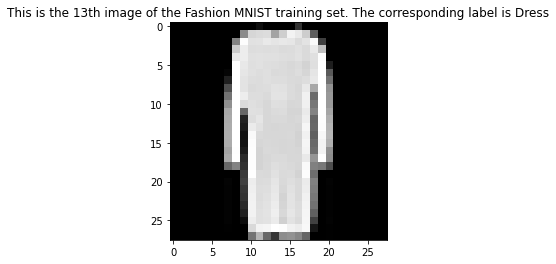

In [5]:
from data_loader import load_fashion_mnist
images, labels = load_fashion_mnist('')
fashion_labels_dictionary = dict()
fashion_labels_dictionary[0] = 'T-shirt/top'
fashion_labels_dictionary[1] = 'Trouser'
fashion_labels_dictionary[2] = 'Pullover'
fashion_labels_dictionary[3] = 'Dress'
fashion_labels_dictionary[4] = 'Coat'
fashion_labels_dictionary[5] = 'Sandal'
fashion_labels_dictionary[6] = 'Shirt'
fashion_labels_dictionary[7] = 'Sneaker'
fashion_labels_dictionary[8] = 'Bag'
fashion_labels_dictionary[9] = 'Ankle boot'

print("The Fashion MNIST training set contains {s} images with {p} pixels each.".format(s = images.shape[0], \
        p = images.shape[1]))

item_number = 25

plt.imshow(images[item_number,:].reshape(28, 28), cmap='gray')
plt.title("This is the 13th image of the Fashion MNIST training set. The corresponding label is {l}".format( \
            l=fashion_labels_dictionary[labels[item_number]]))
plt.tight_layout;

In [8]:
def polynomial_basis(inputs, degree=1):
    X_poly = np.ones(len(inputs))
    for num in range(1,degree+1):
        X_poly = np.c_[X_poly,np.power(inputs,num)]
    return X_poly

In [9]:
data_matrix = polynomial_basis(standardise(images),1)
outputs = one_hot_vector_encoding(labels)

In [10]:
def one_hot_vector_encoding(labels):
    unique = np.unique(labels)
    n = 0
    init_vec = np.zeros(len(labels))
    while n<len(unique):
        k=0
        vec1 = np.zeros(len(labels))
        while k<len(labels):
            if unique[n]==labels[k]:
                vec1[k] = 1
            else:
                vec1[k] = 0 
            k=k+1
        init_vec = np.append(init_vec,vec1)
        n = n+1 
    vect = np.split(init_vec, len(unique)+1)
    del vect[0]
    return np.transpose(vect)
 
    
def standardise(data_matrix):
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return standardised_matrix / row_of_stds

In [11]:
def softmax_function(argument, axis=None):
    argument_a = argument-argument.max(axis =axis, keepdims = True)
    argument_b = np.exp(argument_a)
    return argument_b/argument_b.sum(axis=axis, keepdims = True)

In [12]:
def multinomial_logistic_regression_cost_function(data_matrix, weight_matrix, one_hot_vector_encodings):
    dot_matrix = np.dot(data_matrix,weight_matrix)
    soft = softmax_function(dot_matrix)
    m = data_matrix.shape[0]
    y = one_hot_vector_encodings
    return (-1/m)*(np.sum(y*np.log(soft)+ (1-y)*(np.log(1-soft)),axis = 1))
    
def multinomial_logistic_regression_gradient(data_matrix, weight_matrix, one_hot_vector_encodings):
    multi_grad = np.transpose(data_matrix)@((softmax_function(data_matrix@weight_matrix, axis = 1))-one_hot_vector_encodings)
    return multi_grad

objective = lambda  weight_matrix:  (multinomial_logistic_regression_cost_function(data_matrix, weight_matrix, outputs))
gradient = lambda  weight_matrix:  (multinomial_logistic_regression_gradient(data_matrix, weight_matrix, outputs))

In [13]:
def data_split(data_matrix, outputs, chunks_number):
    no_samples = data_matrix.shape[0]
    indices = np.random.permutation(no_samples)

    m, r = divmod(no_samples, chunks_number)
    indices_split = [
        indices[i * m + min(i, r):(i + 1) * m + min(i, r)] for i in range(chunks_number)
    ]
    data_chunks = [data_matrix[indices_split[i]] for i in range(chunks_number)]
    output_chunks = [outputs[indices_split[i]] for i in range(chunks_number)] 
    return data_chunks , output_chunks

def gradient_descent(objective, gradient, initial_weights, step_size=1, no_of_iterations=100, print_output=10):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective(weights))
    for counter in range(no_of_iterations):
        weights -= step_size * gradient(weights)
        objective_values.append(objective(weights))
        if (counter + 1) % print_output == 0:
            print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1, \
                    m=no_of_iterations, o=objective_values[counter]))
    print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter + 1, \
                m=no_of_iterations, o=objective_values[counter]))
    return weights, objective_values
    

In [14]:
initial_weight_matrix = np.zeros((data_matrix.shape[1], outputs.shape[1]))
optimal_weight_matrix, objective_values = gradient_descent(objective, gradient, initial_weight_matrix, \
                                    step_size=3.9/(np.linalg.norm(data_matrix, 2) ** 2), \
                                    no_of_iterations=40000, print_output=5000)

Iteration 5000/40000, objective = [0.00028711 0.00037594 0.00051502 ... 0.00041687 0.00048836 0.00043484].
Iteration 10000/40000, objective = [0.00035096 0.00045405 0.00059738 ... 0.00049604 0.00056776 0.0005135 ].
Iteration 15000/40000, objective = [0.00039854 0.0005107  0.00065521 ... 0.00055194 0.00062373 0.00056905].
Iteration 20000/40000, objective = [0.00043393 0.00055293 0.00069794 ... 0.00059331 0.00066531 0.0006102 ].
Iteration 25000/40000, objective = [0.00046099 0.00058551 0.00073085 ... 0.00062513 0.00069747 0.00064199].
Iteration 30000/40000, objective = [0.00048259 0.00061171 0.0007574  ... 0.00065068 0.00072344 0.00066766].
Iteration 35000/40000, objective = [0.00050043 0.00063348 0.00077956 ... 0.00067191 0.00074514 0.00068914].
Iteration 40000/40000, objective = [0.00051553 0.000652   0.0007985  ... 0.00068996 0.00076369 0.00070752].
Iteration completed after 40000/40000, objective = [0.00051553 0.000652   0.0007985  ... 0.00068996 0.00076369 0.00070752].


In [15]:
def multinomial_prediction_function(data_matrix,weight_matrix):
    dot_matrix = np.dot(data_matrix,weight_matrix)
    softmax = softmax_function(dot_matrix, axis = 1)
    return np.argmax(softmax, axis = 1)

Use the following space to write your codes. It should be possible to reproduce results that are shown in your report with the codes that are described here. You can outsource functions into separate files if you find that this tidies up your notebook. Any additional libraries that you want to use (e.g. for visualisations etc.) can be loaded here.

In [16]:
predictions = multinomial_prediction_function(data_matrix,optimal_weight_matrix)

In [17]:
def classification_accuracy(true_labels,predicted_labels):
    accuracy = np.mean(true_labels == predicted_labels)
    return accuracy

In [18]:
classification_accuracy(labels, predictions)

0.8784833333333333

In [21]:
array1 = confusion_matrix(labels,predictions)

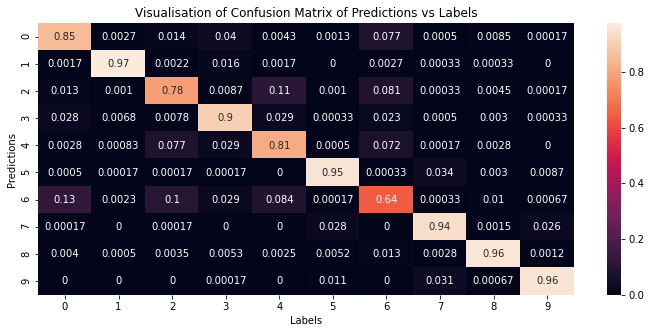

In [46]:
plt.figure(figsize = (12,5))
sns.heatmap(array1/6000,annot = True)
plt.xlabel("Labels")
plt.ylabel("Predictions")
plt.title("Visualisation of Confusion Matrix of Predictions vs Labels")
plt.show()

In [27]:
array1

array([[5112,   16,   84,  239,   26,    8,  460,    3,   51,    1],
       [  10, 5850,   13,   97,   10,    0,   16,    2,    2,    0],
       [  80,    6, 4687,   52,  651,    6,  488,    2,   27,    1],
       [ 169,   41,   47, 5408,  173,    2,  137,    3,   18,    2],
       [  17,    5,  462,  175, 4886,    3,  434,    1,   17,    0],
       [   3,    1,    1,    1,    0, 5721,    2,  201,   18,   52],
       [ 770,   14,  607,  177,  503,    1, 3861,    2,   61,    4],
       [   1,    0,    1,    0,    0,  168,    0, 5665,    9,  156],
       [  24,    3,   21,   32,   15,   31,   77,   17, 5773,    7],
       [   0,    0,    0,    1,    0,   65,    0,  184,    4, 5746]],
      dtype=int64)

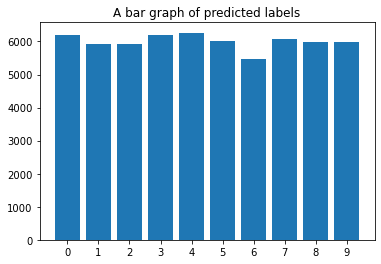

In [49]:
unique_labels =np.unique(predictions, return_counts = True)[0]
unique_counts = np.unique(predictions,return_counts = True)[1]
plt.bar(unique_labels, unique_counts)
plt.title("A bar graph of predicted labels")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

In [34]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

In [50]:
np.unique(predictions, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([6186, 5936, 5923, 6182, 6264, 6005, 5475, 6080, 5980, 5969],
       dtype=int64))

This completes the MTH786 coding project requirements. Please do not forget to write a detailed report on your findings (at most 8 pages) with $\LaTeX$ and your favourite editor. If no editor is at hand, please feel free to use online editors such as [Overleaf](https://www.overleaf.com).